In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in the words
words = open('/Users/rajesh/Documents/Datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# Build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtrg, Ytrg = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# Set up the MLP (multi-layer perceptron)
n_embd = 10     # Dimensionality of the character embedding vectors
n_hidden = 200  # Number of neurons in the hidden layer of the MLP

# Set up the network parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
for p in parameters:
    p.requires_grad = True

In [9]:
sum(p.nelement() for p in parameters) # Number of parameters

11897

In [10]:
# Set up training of the neural network
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Construct minibatch
    idx = torch.randint(0, Xtrg.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrg[idx], Ytrg[idx]     # batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Parameter update
    eta = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -eta * p.grad
        
    # Track progress statistics
    if i % 10000 == 0:
            print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

# print(loss.item())

      0 /  200000 : 27.8817
  10000 /  200000 : 2.9550
  20000 /  200000 : 2.5960
  30000 /  200000 : 2.8739
  40000 /  200000 : 2.0954
  50000 /  200000 : 2.4711
  60000 /  200000 : 2.4224
  70000 /  200000 : 2.1450
  80000 /  200000 : 2.3150
  90000 /  200000 : 2.3512
 100000 /  200000 : 2.0754
 110000 /  200000 : 2.4186
 120000 /  200000 : 1.9340
 130000 /  200000 : 2.4763
 140000 /  200000 : 2.2390
 150000 /  200000 : 2.1413
 160000 /  200000 : 2.1554
 170000 /  200000 : 1.8018
 180000 /  200000 : 2.0026
 190000 /  200000 : 1.8852


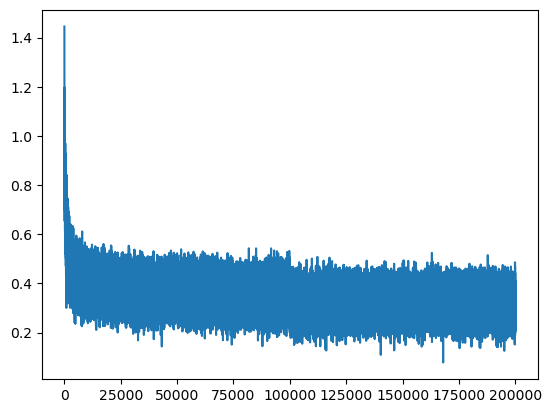

In [11]:
# Plot Steps against the Loss
plt.plot(lossi)

In [12]:
# Calculate the training and validation set loss

@torch.no_grad()     # Decorator to tell PyTorch that the code below does not require bookkeeping for gradients
                     # This improves execution efficiency
    
def calculate_split_loss(split):
    x,y = {
        'train': (Xtrg, Ytrg),
        'val': (Xval, Yval),
        'test': (Xtst, Ytst)
    }[split]
    
    emb = C[x]     # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)        # hidden layer activation (N, n_hidden)
    logits = h @ W2 + b2                    # output layer activation (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
calculate_split_loss('train')
calculate_split_loss('val')

    
    

train 2.1276285648345947
val 2.172778606414795


In [14]:
# Sample from the model
g= torch.Generator().manual_seed(2147473647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size     # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])]        # (1, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
        h = torch.tanh(embcat @ W1 + b1)        # hidden layer activation (N, n_hidden)
        logits = h @ W2 + b2                    # output layer activation (N, vocab_size)
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(idx)
        # Shift the context window
        context = context[1:] + [idx]
        # Break if we sample the special token '.'
        if (idx == 0):
            break
            
    # Decode and print the generated names
    print(''.join(itos[i] for i in out))

mazili.
nestoruetton.
xadal.
meran.
semy.
keana.
xis.
wan.
jayley.
nouk.
afaixty.
hazmet.
zerrinn.
ariak.
kaylyn.
josandristoryel.
colie.
arna.
nah.
araley.


In [ ]:
# Issues with the neural network
# Intial loss is very high ~28.887
# This is because the weights and biases when initialized to random numbers take on very large values.
# The first few epochs are spent squashing down these randomly initialized high weights.

# Trick: Multiply the weights by 0.1 or 0.01

In [20]:
# Set up the MLP (multi-layer perceptron)
n_embd = 10     # Dimensionality of the character embedding vectors
n_hidden = 200  # Number of neurons in the hidden layer of the MLP

# Set up the network parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.3
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.3
b2 = torch.randn(vocab_size, generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]

In [21]:
for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # Number of parameters

11897

In [22]:
# Train the neural network

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Construct minibatch
    idx = torch.randint(0, Xtrg.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrg[idx], Ytrg[idx]     # batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Parameter update
    eta = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -eta * p.grad
        
    # Track progress statistics
    if i % 10000 == 0:
            print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

# print(loss.item())

      0 /  200000 : 7.2157
  10000 /  200000 : 2.0785
  20000 /  200000 : 2.3764
  30000 /  200000 : 2.4629
  40000 /  200000 : 1.9597
  50000 /  200000 : 2.4472
  60000 /  200000 : 2.3848
  70000 /  200000 : 2.1217
  80000 /  200000 : 2.1824
  90000 /  200000 : 2.1229
 100000 /  200000 : 1.8579
 110000 /  200000 : 2.1681
 120000 /  200000 : 1.8689
 130000 /  200000 : 2.4107
 140000 /  200000 : 2.2492
 150000 /  200000 : 2.1073
 160000 /  200000 : 1.7896
 170000 /  200000 : 1.7932
 180000 /  200000 : 1.9447
 190000 /  200000 : 1.7898


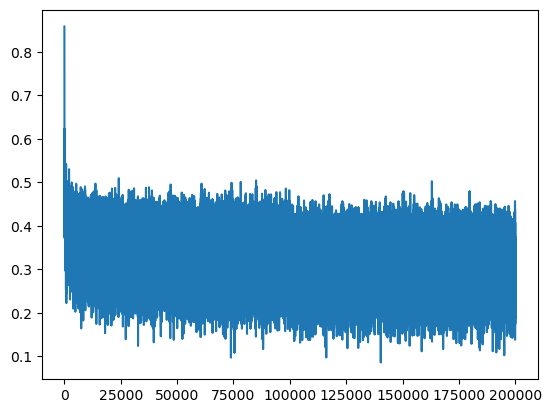

In [23]:
# Plot the loss
plt.plot(lossi)

In [24]:
# Calculate training and validation loss

calculate_split_loss('train')
calculate_split_loss('val')

train 2.0425596237182617
val 2.104320764541626


In [ ]:
# Notes:
# The loss for the first epoch is 7.21
# The training and validation losses are better than what we got previously with randomly initialized weights

# The issue with the tanh activation function is that large values of pre-activation will result in tanh giving -1 or +1
# Neurons where the activation is either -1 or +1 for all inputs are effectively deade neurons (with 0 gradient). These will not learn.
# This is another reason to make sure that weight initialization is done carefully (like we did above)
# There is a very principled way of weight initialization depending on the loss function that uses gain / sqrt(fan_in) as the multiplicative factor.

# More recent innovations that we will discuss next make it less important to so carefully initialize the weights.

# Video: 40:47
